# SI 650 / EECS 549: Homework 3 Part 2

Homework 3 Part 2 will have you working with Learning to Rank approaches, which as we've seen are highly competitive when enough data is available. Part 2 should be completed after Part 1 and will use some small parts of that code to construct an index and load data.

If you haven't worked with them before, Part 2 will expose you to [overloaded python operators](https://www.geeksforgeeks.org/operator-overloading-in-python/), which will let you call functions using alternative python syntax. For example, if you're using two Python `list` objects, you can interact with them using `+` to call the equivalent method. 

In Part 2, you'll work on the following tasks:
 - Construct and learn learning-to-rank pipelines
 - Add new features for learning-to-rank
 - Evaluate learning-to-rank models
 
Part 2 can be run on most laptops as well. Some of the machine learning models may take a few minutes to train but you are also welcome to run these on Great Lakes. None of the code in this part involves deep learning or requires a GPU.

### Launch PyTerrier
Import the packages you need and launch PyTerrier like we did in Part 1. You will still need to make sure `JAVA_HOME` is set for this part.

In [ ]:
! pip install python-terrier

     |████████████████████████████████| 95 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 22.4 MB/s 
     |████████████████████████████████| 69 kB 4.6 MB/s 
     |████████████████████████████████| 222 kB 72.4 MB/s 
     |████████████████████████████████| 6.3 MB 47.8 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 
     |████████████████████████████████| 126 kB 93.2 MB/s 
     |████████████████████████████████| 294 kB 60.9 MB/s 
     |████████████████████████████████| 72 kB 1.9 MB/s 
     |████████████████████████████████| 1.8 MB 64.9 MB/s 
     |████████████████████████████████| 291 kB 58.3 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.7.1-py3-none-any.whl size=102452 sha256=1a7ff6c2bdfa31c0fe31acab71b9b283941f228174f18e9fafe7b6fd543dc242
  Stored in directory: /root/.cache/pip/wheels/c0/9a/c8/1c2d9ec6a1494bb54f47e0d2627b5ed7b2de704b66723d3417
  Created wheel for ir-measures: filen

In [ ]:
import pyterrier as pt
import pandas as pd
import os

In [ ]:
if not pt.started():
    pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.7.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


# Indexing CORD19

Like in Part 1, we'll again use the CORD19 data. However, **in Part 2, we will add in positional indexing.** This code will still look very similar to your code from Part 1. When creating the index, add the `blocks=True` argument, which will include word order information in the index. On most laptops, this process will take ~1 minute.

You may see an error `java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755` during indexing but you can safely ignore the error for the purposes of this notebook.

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './terrier_trec_covid_positional_indices'

if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer 

    # TODO
    indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    
    # TODO
    index_ref = indexer.index(cord19.get_corpus_iter(), 
                              fields=('abstract',), 
                              meta=('docno',))
else:
    # if you already have the index, use it.
    
    # TODO
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(index_ref)

[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
[INFO] [finished] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: [00:04] [269MB] [64.6MB/s]
[INFO] [starting] building docstore
docs_iter: 100%|████████████████████| 192509/192509 [00:10<00:00, 17906.66doc/s]
[INFO] [finished] docs_iter: [00:10] [192509doc] [17904.86doc/s]
[INFO] [finished] building docstore [10.76s]


cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

03:45:24.102 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
03:46:38.610 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents
03:46:39.666 [ForkJoinPool-1-worker-3] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BlockIndexer.createDirectIndex(BlockIndexer.java:472)
	at org.terrier.structures.indexing

## Transformers and Operators

PyTerrier works extensively with objects/functions that _transform_ one input to another. We saw this behavior with the `BatchRetrieve` object that we used earlier to get search results, which had a `transform()` method that takes as input a dataframe, and returns another dataframe. We can think of this function as a *transformation* of the earlier dataframe (e.g., transforming the queries into results). PyTerrier has many such functions that act as  [transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html). 

Let's use the transformer, `BatchRetrieve`, and this time specify that we'll use the TF-IDF word model.

In [ ]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

In PyTerrier, all transformers have been coded so that they be combined using Python operators, which is an example  of operator overloading. If we want to have the output of one transformer used as the input of another transformer, we can use the `>>` operator. This operator lets us compose a series of transformations to output our document rankings.

In [ ]:
# This is our first retrieval transformer, which transforms a queries dataframe to a results dataframe
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf( cord19.get_topics(variant='title').head(1) )

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [9.82MB/s]


,qid,docid,docno,rank,score,query
0,1,146967,jkrj0lbm,0,25.0,coronavirus origin
1,1,25564,jlzncyax,1,18.0,coronavirus origin
2,1,45549,8l411r1w,2,15.0,coronavirus origin
3,1,29359,gnxbfcod,3,14.0,coronavirus origin
4,1,63537,cpc6v40g,4,14.0,coronavirus origin
...,...,...,...,...,...,...
995,1,58583,wfcyaumm,995,4.0,coronavirus origin
996,1,59153,86vu0kjm,996,4.0,coronavirus origin
997,1,59343,9n733bet,997,4.0,coronavirus origin
998,1,59478,mx58ai55,998,4.0,coronavirus origin


Let's define our first pipeline using the `>>` operator. If we have two transformers, `a` and `b`, the result of `a >> b` is itself a transformer!

In [ ]:
pipeline = tf >> tfidf

We can use this pipeline like any other transformer. Here, we'll  pass in the very first query using `head(1)` and get the results

In [ ]:
pipeline(cord19.get_topics(variant='title').head(1))

[INFO] NumExpr defaulting to 2 threads.


,qid,docid,docno,rank,score,query
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin
3,1,93245,hmvo5b0q,3,6.507303,coronavirus origin
4,1,84953,ax6v6ham,4,6.483723,coronavirus origin
...,...,...,...,...,...,...
995,1,136214,ygnxmcl1,995,1.640752,coronavirus origin
996,1,91270,853ipgea,996,1.634118,coronavirus origin
997,1,146556,oshov14d,997,1.634118,coronavirus origin
998,1,32462,xtfjw1ag,998,1.592462,coronavirus origin


There many other PyTerrier operators and please see examples in the [PyTerrier documentation on operators](https://pyterrier.readthedocs.io/en/latest/operators.html)

## Task 1: Pipeline Construction (15 ponts)

Create a ranker that performs the following:
 - obtains the top 10 highest scoring documents by term frequency (`wmodel="Tf"`)
 - obtains the top 10 highest scoring documents by TF.IDF (`wmodel="TF_IDF"`)
 - reranks only those documents found in BOTH of the previous retrieval settings using BM25.

How many documents are retrieved by this full pipeline for the query `"chemical"`.
> If you obtain the correct solution, the document with docno `"37771"` should have a score of $12.426309	$ for query `"chemical"`.

Hints:
 - choose carefully your [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - you should not need to perform any Pandas dataframe operations

In [ ]:
# TODO
tf_10 = pt.BatchRetrieve(index, wmodel="Tf") % 10
tfidf_10 = pt.BatchRetrieve(index, wmodel="TF_IDF") % 10
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
mypipeline = (tf_10 & tfidf_10) >> bm25
mypipeline("chemical")

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:544: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  res = self.transformer.transform(topics_and_res)
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:544: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  res = self.transformer.transform(topics_and_res)


,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,12.426309,chemical
1,1,134305,0smev8vt,1,12.292890,chemical
2,1,142104,77c9ohxj,2,12.226076,chemical
3,1,56631,sps45fj5,3,11.642770,chemical
4,1,2524,ifebw24e,4,11.439890,chemical


## Developing more complex transformers pipelines

PyTerrier has a number of useful transformers that we can use to create complex retrieval pipelines. For composing pipelines, let's first define a bit of notation:
 - $Q$: a set of queries
 - $D$: a set of documents
 - $R$: a set of retrieved documents for a set of queries

In our setting, we'll use three transformers:
 - `pt.BatchRetrieve(index, wmodel="BM25")` - input $Q$ or $R$ (retrieval or reranking), output $R$
 - `pt.rewrite.SDM()` (sequential dependence proximity model) - input $Q$, output $Q$. 
 - `pt.rewrite.Bo1QueryExpansion(index)` - input $R$, output $Q$.

Note that now, we're using BM25 instead of TF-IDF to retrieve documents.

Transformers like `SDM` are performing query augmentation. Here, `SDM` is reweighting terms using a Dirichlet language model like we talked about in class. However, many query rewrites a possible! For example, we could use WordNet to expand the query with synonyms or even define our own. 

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

Let's see how `sdm` applies to a given query. This generates a query in an [Indri-like query language](https://www.lemurproject.org/lemur/IndriQueryLanguage.php) that Terrier (cf. `pt.BatchRetrieve()`) can understand.
 - `#combine()` - is used for weighting sub-expressions
 - `#1() - matches as a phrase, i.e. how many times do the constituent words exactly match as a phrase
 - `#uw8()` and `#uw12()` look for how many times the constituent words appear in unordered windows of 8 or 12 tokens.
 - finally, the weighting model is overridden for these query terms.
  

In [ ]:
sdm.search("chemical reactions").iloc[0]["query"]

'chemical reactions #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#1(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw8(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw12(chemical reactions))'

## Task 2.1: Creating Experiments to test Pipelines (3 points)

Which kinds of rankers will perform better? We can answer this by creating an [Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html) that will compare sequential dependence model and Bo1 query expansion on TREC CORD19 with the BM25 baseline. We used Experiments in Part 1, so we'll expand this idea again here to test out different pipelines.

**Your Task:** You will need to construct appropriate pipelines to compare each approach by considering the input and output datatypes of the `bm25`, `sdm` and `qe`. 

In [ ]:
topics = cord19.get_topics(variant='title')
qrels = cord19.get_qrels()

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:00] [1.14MB] [3.63MB/s]


In [ ]:
# TODO
from pyterrier.measures import nDCG
pt.Experiment(
    [bm25, sdm >> bm25, bm25 >> qe >> bm25], 
    topics,
    qrels,
    names=["BM25",  "SDM + BM25", "BM25 + QueryExpansion + BM25"],
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10]
)

,name,map,ndcg,nDCG@5,nDCG@10
0,BM25,0.181478,0.373328,0.611724,0.583665
1,SDM + BM25,0.181982,0.373439,0.613116,0.586512
2,BM25 + QueryExpansion + BM25,0.190398,0.388397,0.619323,0.580906


### Task 2.2:  Reflection (2 points)

Which approaches result in significant increases in NDCG and MAP? Is NDCG@10 also improved? Write 2-3 sentences why you think this is the case.

From the table above, we can see that `qe` has a best performance based on the nDCG@5 and MAP metrics among three pipelines. However, the performance on nDCG@10 of `qe` does not improved. 

The decrease of nDCG@10 may lies in the fact that query augmentation expandes the seaching range while including those less relevent documents. Hence it appears to be an increase on nDCG@5 and a decrease on nDCG@10.

# Learning to Rank

Now that we have some idea how to build pipelines in PyTerrier, we'll continue our exploration by constructing and evaluating Learning to Rank pipelines.

Learning to rank is fundamentally a machine learning approach to IR. To work, we'll need to create _training data_ to learn our ranking model. We'll also want development ("dev") data to evaluate hyperparameters and test data to see how well it works. Our dataset doesn't by itself already have the data split into train, dev, and test, so we'll first need to do that.

TREC Covid only has 50 topics, which isn't a lot for training in general. However, for a homework, 50 is sufficient to show you how it works. In this case, we'll split this 30 for training (60%), 5 for validation (10%), and 15 for evaluation (30%). In your projects, you'll want to test for statistical significance (i.e., is the improvement better than what could be expected by chance?) so we will also examine statistical significance, though we have limited data (15 topics) to do this with.

When training our model, we will only re-rank the top 500 documents for each query, which is hopefully sufficient data for learning to rank. We don't set the model to rerank _all_ documents (though you can try this!) since it causes us to have to train the Learning to Rank model on all data and is often very slow in practice.

In [ ]:
RANK_CUTOFF = 10
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

## Defining a Feature Set for Learning to Rank

Learning to Rank requires that we define which features to use in determining a ranking. We can use scores like BM25 but it's common to try adding more complex features that take advantage of what you, the IR practitioner, knows about the data or features that would be useful.

For this part, we'll start with 7 features. PyTerrier provides [extensive support](https://pyterrier.readthedocs.io/en/latest/ltr.html#) for how to define features and calculate them for Learning to Rank. We recommend reading that documentation as you start to go over the code below. Note that several of these features will use more than just the text to compute relevance!

1.   the BM25 abstract score;
2.   sequential dependence model, scored by BM25;
3.   does the abstract contain 'coronavirus covid', scored by BM25;
4.   the BM25 score on the title (even though we didn't index it earlier!);
5.   was the paper released/published in 2020? Recent papers were more useful for this task;
6.   does the paper have a DOI, i.e. is it a formal publication?
7.   the coordinate match score for the query--i.e. how many query terms appear in the abstract.

Several of these feature require additional metadata `["title", "date", "doi"]`, which is present in the TREC covid dataset. Fortunately, we can obtain this metadata after indexing using `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns from the original data.

There is a lot going on in this code block, but it's useful to think of this as _another_ example of operator overloading in PyTerrier. Here, we're combining features using the `**` operator, which is the [feature union](https://pyterrier.readthedocs.io/en/latest/ltr.html#calculating-features) operator in PyTerrier. 

The output of our feature union is the `ltr_feats1` object which is itself a transformer we can use to start ranking.

In [ ]:
ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') ) 
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

# for reference, lets record the feature names here too
fnames=["BM25", "SDM", 'coronavirus covid', 'title', "2020", "hasDoi", "CoordinateMatch"]

To get a sense of what this process is doing, let's look at the output for the query "coronavirus origin". We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the `"features"` column, which is what we'll use for learning. 

In [ ]:
ltr_feats1.search("coronovirus origin")

03:47:06.966 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,188321,8bn74f2z,0,20.541477,coronovirus origin,Reply to Comments on 'Co‐infection of SARS‐CoV...,2020-04-08,10.1002/jmv.25838,"[20.541476673741375, 20.541476673741375, 2.899..."
1,1,93090,ciqs6l7e,1,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health...,2020,,"[19.859401180444888, 19.859401180444888, 2.803..."
2,1,93091,qe9w4qbu,2,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health...,2020,,"[19.859401180444888, 19.859401180444888, 2.803..."
3,1,152453,egzztatj,3,19.459604,coronovirus origin,The spread of the COVID‐19 coronavirus: Health...,2020-03-17,10.15252/embr.202050334,"[19.459604473560834, 19.459604473560834, 2.747..."
4,1,105298,9ci1u50r,4,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothe...,2020,,"[18.009390548413062, 18.009390548413062, 0.0, ..."
5,1,175511,kdo2hir8,5,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothe...,2020-05-12,10.1177/1093526620925569,"[18.009390548413062, 18.009390548413062, 0.0, ..."
6,1,97984,76laky91,6,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
7,1,97985,niytf3wo,7,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
8,1,97986,262bcl7h,8,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
9,1,97987,nip1ax1x,9,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."


We can also look at the raw feature values themselves too. Here, we'll look at the features for the first document. Note that the BM25 in the "score" column above is also the first value in the feature array (20.54), because we used an identity transformer, which returns the same value as its input.

In [ ]:
ltr_feats1.search("coronovirus origin").iloc[0]["features"]

03:47:07.329 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


array([20.54147667, 20.54147667,  2.89976767,  0.        ,  1.        ,
        1.        ,  1.        ])

## Actually Doing the Learning for Learning to Rank

In class, we talked about three types of Learning to rank: pointwise, pairwise, and listwise. Here, we'll train a few models for two of these types, listwise and pointwise. 

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

We can use the same feature pipeline, `ltr_feats1`, with all three.  To train the ranker, we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels, much like how we train models with Scikit-Learn. Importantly, the preceding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtain the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set--similarly the validation topics are transformed into validation results.

Finally, `%time` is notebook "magic command" specific to Juypyter which displays how long learning takes for each technique. Learning for each technique takes under 30 seconds.

In [ ]:
! pip install fastrank

     |████████████████████████████████| 891 kB 7.6 MB/s 


In [ ]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, cord19.get_qrels())

03:47:14.217 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1f4279bd0>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 1min 40s, sys: 486 ms, total: 1min 41s
Wall time: 58.3 s


Now, let's try learning a different pointwise model to estimate relevance scores using a Random Forest model from Scikit-Learn. This is a good example of how we can use off-the-shelf regression models in PyTerrier to perform learning to rank.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, cord19.get_qrels())

03:48:12.124 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1f4279bd0>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.9s


CPU times: user 16.4 s, sys: 236 ms, total: 16.7 s
Wall time: 10.7 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    5.7s finished


Finally, let's use a list-wise approach, which typically performs best among the three types of Learning to Rank

In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

03:48:23.296 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1f4279bd0>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


03:48:25.587 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1f4279bd0>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@10: 0.810625
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's ndcg@10: 0.802417
[3]	valid_0's ndcg@10: 0.838307
[4]	valid_0's ndcg@10: 0.834587
[5]	valid_0's ndcg@10: 0.822182
[6]	valid_0's ndcg@10: 0.82273
[7]	valid_0's ndcg@10: 0.82273
[8]	valid_0's ndcg@10: 0.82273
Early stopping, best iteration is:
[3]	valid_0's ndcg@10: 0.838307
CPU times: user 45.9 s, sys: 476 ms, total: 46.3 s
Wall time: 26.7 s


## Evaluating all the solutions 

We've fit the three Learning to Rank models so we can now use them to predict relevance scores for the held-out 15 topics (queries) in our test set. Note that if we wanted to do any tuning (e.g., pick the number of leaves in our `RandomForestRegressor`, we could run this evaluation on our held-out _dev_ set and pick the hyperparameters that produced best performance on it).

### Task 3: Create an experiment to compare (5 points)

Create a new `Experiment` to compare our three solutions and BM25 at the `RANK_CUTOFF` (four models in total). Report MAP, NDCG, and NDCG@10 measures and one new measure: mean response time (`"mrt"`), which will tell us how fast the models are able to score documents--something important if we're going to use them in the real world!

In [ ]:
# TODO
# Set division: train_topics, valid_topics, test_topics
# Trained models: ca_pipe, rf_pipe, lmart_x_pipe
from pyterrier.measures import nDCG

pt.Experiment(
    [bm25 % RANK_CUTOFF, ca_pipe, rf_pipe, lmart_x_pipe], 
    test_topics,
    cord19.get_qrels(),
    names=["BM25",  "BM25 + CA", "BM25 + RF", "BM25 + LMart"],
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"]
)

03:48:48.880 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:48:50.652 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


03:48:52.736 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt
0,BM25,0.010480,0.043844,0.537236,40.425697
1,BM25 + CA,0.012178,0.048968,0.579148,113.776699
2,BM25 + RF,0.011271,0.045830,0.551404,136.641623
3,BM25 + LMart,0.009980,0.042855,0.529670,116.676185


Thats really interesting – all three learned models could improve NDCG@10 over BM25, but the coordinate ascent model improved the most (significantly so on all three metrics, but again on only 15 queries). Coordinate Ascent improved upto 10 queries.

## Analysis: What Features Matter?

Since we're _learning_ a ranking model, we can inspect that model to see what information it's using. One option for inspecting the model is to evaluate the performance of each feature independently to see how much it contributes to the eventual relevance. To examine each feature, we will create separate a separate model from each feature in our feature pipeline (`ltr_feats1`) by using `pt.ltr.feature_to_score(i)` with a particular feature number $i$. In essence, this will only score the relevance using a single feature's values, even though we've already calculated all of them.

In [ ]:
pt.Experiment(
    [ltr_feats1 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])

03:48:54.555 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:48:56.294 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:48:58.002 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:48:59.773 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25,0.010480,0.043844,0.537236,95.0
1,SDM,0.010429,0.043568,0.535770,95.0
2,coronavirus covid,0.011637,0.046777,0.562223,95.0
3,title,0.011799,0.047354,0.567363,95.0
4,2020,0.011064,0.045604,0.555846,95.0
5,hasDoi,0.009928,0.042970,0.531974,95.0
6,CoordinateMatch,0.010742,0.044333,0.540893,95.0


### Inspecting the models

To get a sense of feature importance, we can also analyze the learned models themselves using their internal feature weights in the Scikit-Learn models. Here, we'll plot the feature importances in a few ways. For the coordinate ascent model, we plot the feature weights (note the log-scale y-axis); while for the regression-tree based techniques, we report the feature importance.

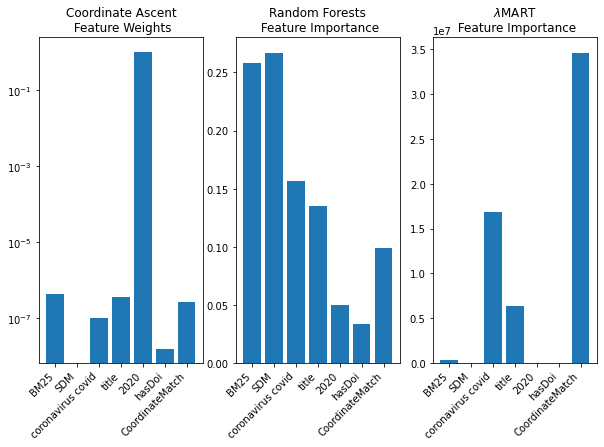

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()

## Task 4: Adding new features (15 points)

We've seen how to develop Learning to Rank models and analyze features. Your task is the following:

  - Define _at least_ two additional features to use in learning to rank models. These can be functions that you define or additional options from PyTerrier
  - Include your new features in a new learning to rank pipeline using the three approaches we have above to create three new models
  - Evaluate your new models against the old models in an Experiment
 
**Full credit will depend on one of your new models outperforming the best of the initial three models.**

You should aim to evaluate your features initially on the `dev` set, rather than the `test` set in order to avoid overfitting your features (i.e., never look at the test set until the end). You can use the feature and model inspection code to give you some idea of what the model is looking at. We also recommend looking at the data directly to think about what kinds of features might be useful

In [ ]:
# TODO
# tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
ltr_feats2 = (bm25 % RANK_CUTOFF) >> \
    pt.text.get_text(cord19, ["title", "date", "doi"]) >> \
    (
        pt.transformer.IdentityTransformer()
        ** # sequential dependence
        (sdm >> bm25)
        ** # additional feature: score of text for query 'pandemic'
        (pt.apply.query(lambda row: 'pandemic') >> bm25)
        ** # additional feature: TF-IDF indicator
        pt.BatchRetrieve(index, wmodel="TF_IDF")
        ** # score of text for query 'coronavirus covid'
        (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
        ** # score of title (not originally indexed)
        (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') ) 
        ** # date 2020
        (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
        ** # has doi
        (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
        ** # abstract coordinate match
        pt.BatchRetrieve(index, wmodel="CoordinateMatch")
    )

myfnames=["BM25", "SDM", "TF-IDF", 'coronavirus covid', 'title', "2020", "hasDoi", "CoordinateMatch"]

In [ ]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe2.fit(train_topics, cord19.get_qrels())

05:52:50.805 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1d8149210>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 32min 6s, sys: 5.99 s, total: 32min 12s
Wall time: 19min 41s


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe2.fit(train_topics, cord19.get_qrels())

06:12:32.262 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1d8149210>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min


CPU times: user 4min 59s, sys: 2.04 s, total: 5min 1s
Wall time: 2min 43s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  2.3min finished


In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe2.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

06:20:03.247 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1d8149210>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


06:20:23.363 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fe1d8149210>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@10: 0.852789
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's ndcg@10: 0.852789
[3]	valid_0's ndcg@10: 0.852789
[4]	valid_0's ndcg@10: 0.852789
[5]	valid_0's ndcg@10: 0.852789
[6]	valid_0's ndcg@10: 0.852789
Early stopping, best iteration is:
[1]	valid_0's ndcg@10: 0.852789
CPU times: user 2h 6s, sys: 8.97 s, total: 2h 15s
Wall time: 1h 1min 27s


In [ ]:
# Set division: train_topics, valid_topics, test_topics
# Trained models: ca_pipe2, rf_pipe2, lmart_x_pipe2
from pyterrier.measures import nDCG

pt.Experiment(
    [bm25 % RANK_CUTOFF, ca_pipe, rf_pipe, lmart_x_pipe, ca_pipe2, rf_pipe2, lmart_x_pipe2], 
    test_topics,
    cord19.get_qrels(),
    names=["BM25", "BM25 + CA", "BM25 + RF", "BM25 + LMart", "BM25 + CA (updated)", "BM25 + RF (updated)", "BM25 + LMart (updated)"],
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"]
)

07:21:33.722 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
07:21:35.523 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


07:21:37.540 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
07:21:39.362 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
07:21:41.259 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


07:21:43.618 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt
0,BM25,0.010480,0.043844,0.537236,38.593180
1,BM25 + CA,0.012178,0.048968,0.579148,114.460892
2,BM25 + RF,0.011271,0.045830,0.551404,133.080325
3,BM25 + LMart,0.009980,0.042855,0.529670,109.557069
4,BM25 + CA (updated),0.012243,0.049223,0.582589,120.722511
5,BM25 + RF (updated),0.011537,0.047402,0.562495,141.596972
6,BM25 + LMart (updated),0.009926,0.042458,0.528034,133.389319


According to the performance table above, we can see that the `BM25 + CA (updated)` with the additional two features has a better performance comparing to orginal best model `BM25 + CA` based on all three evaluation metrics (`map`, `ndcg`, `ndcg_cut_10`). It indicates that our additional two features work.